In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
path = '/kaggle/input/playground-series-s4e3/'

train_data = pd.read_csv(path + 'train.csv')
original_data = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')
test_data = pd.read_csv(path + 'test.csv')
TARGET_FEATURES = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']

train_data.drop(['id'],axis = 1,inplace = True)
test_data.drop(['id'],inplace = True,axis = 1)
train_data = pd.concat([train_data,original_data],axis = 0)
train_data.reset_index(drop=True, inplace=True)

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21160 entries, 0 to 21159
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Em

In [3]:
def feature_engineering(data):
    data['Ratio_Length_Thickness'] = data['Length_of_Conveyer'] / data['Steel_Plate_Thickness']
    data['X_Range*Pixels_Areas'] = (data['X_Maximum'] - data['X_Minimum']) * data['Pixels_Areas']
    data['Average_Luminosity'] = data['Sum_of_Luminosity'] / data['Pixels_Areas']
    return data

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

#### Target 분포

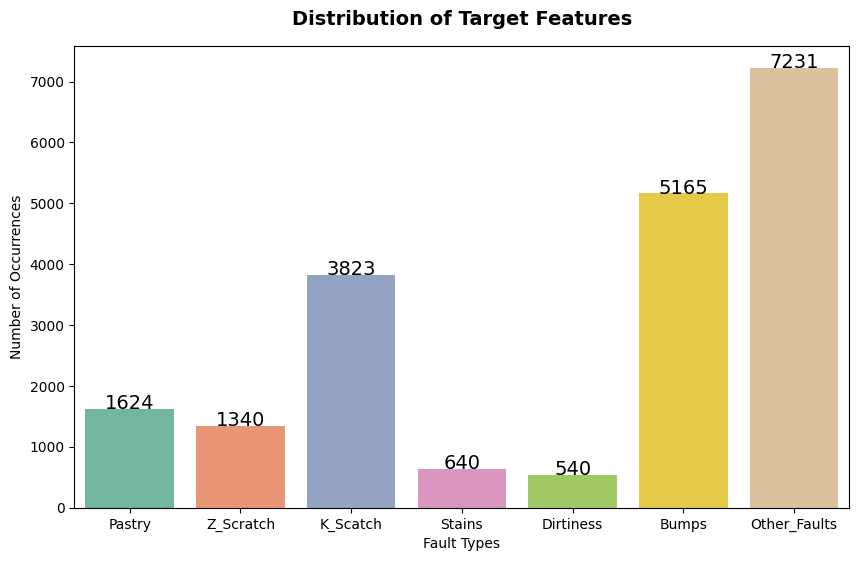

In [4]:
# Sum the occurrences of each target feature
target_sums = train_data[TARGET_FEATURES].sum()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=target_sums.index, y=target_sums.values, palette='Set2')
plt.title("Distribution of Target Features", fontweight="black", size=14, pad=15)
for i, v in enumerate(target_sums.values):
    plt.text(i, v, str(v), ha="center", fontsize=14)
plt.xticks()
plt.xlabel('Fault Types')
plt.ylabel('Number of Occurrences')
plt.show()

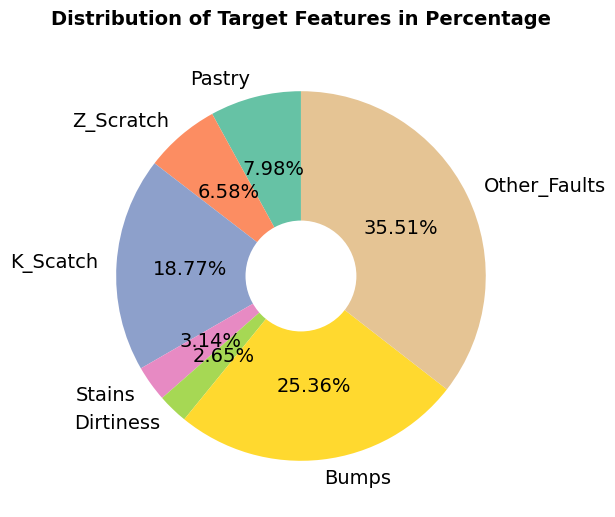

In [5]:
# Pie chart
plt.figure(figsize=(10, 6))
colors = sns.color_palette('Set2', len(target_sums))
plt.pie(target_sums, labels=target_sums.index, autopct="%.2f%%", textprops={"size": 14},
        colors=colors, startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of Target Features in Percentage", fontweight="black", size=14, pad=15)
plt.show()

#### Ratio_Length_Thickness

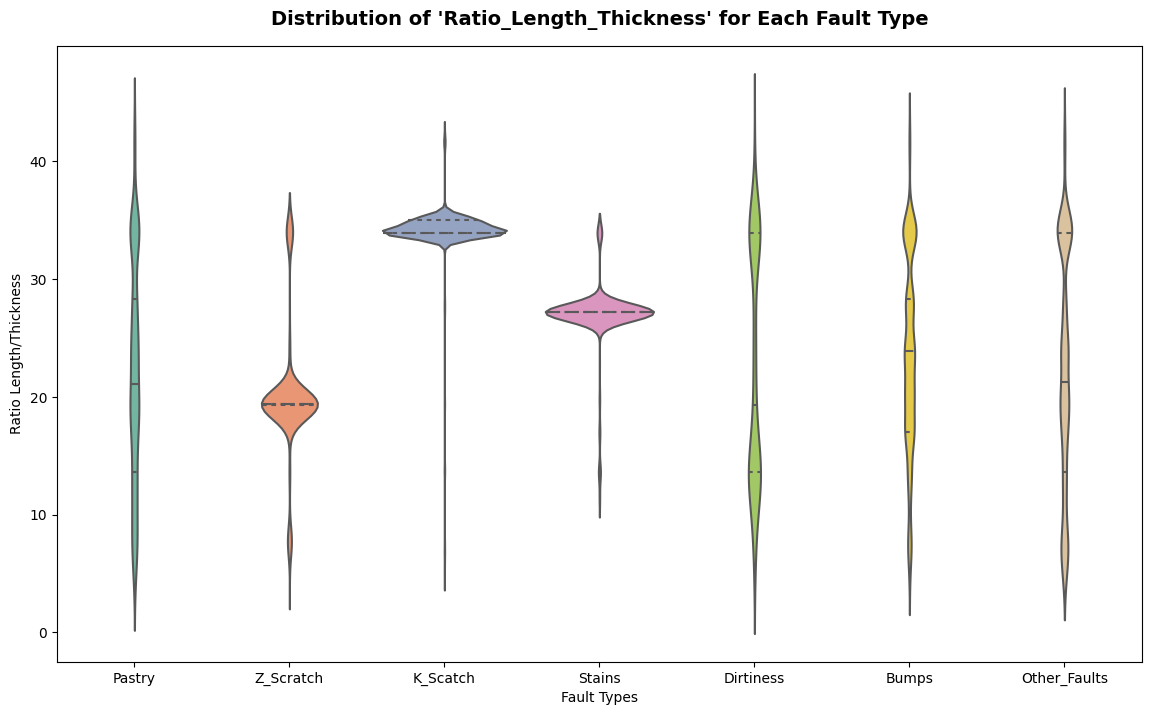

In [6]:
# Create a new DataFrame for plotting
plot_data = pd.melt(train_data, id_vars=['Ratio_Length_Thickness'], value_vars=TARGET_FEATURES, 
                    var_name='Fault_Type', value_name='Occurrence')

# Filter out rows where the occurrence is 0
plot_data = plot_data[plot_data['Occurrence'] > 0]

# Plotting
plt.figure(figsize=(14, 8))
palette = sns.color_palette("Set2", len(TARGET_FEATURES))
sns.violinplot(x='Fault_Type', y='Ratio_Length_Thickness', data=plot_data, inner='quartile', palette=palette)
plt.title("Distribution of 'Ratio_Length_Thickness' for Each Fault Type", fontweight="black", size=14, pad=15)
plt.xticks()
plt.xlabel('Fault Types')
plt.ylabel('Ratio Length/Thickness')
plt.show()

#### Average_Luminosity

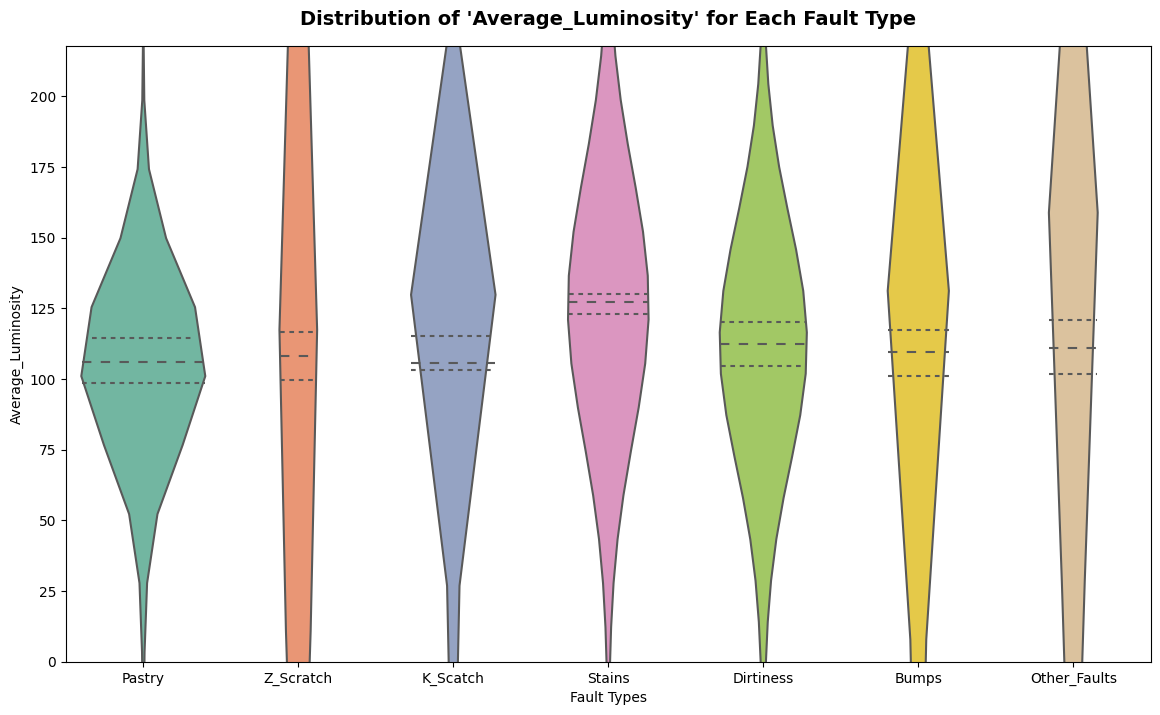

In [7]:
# Create a new DataFrame for plotting
plot_data = pd.melt(train_data, id_vars=['Average_Luminosity'], value_vars=TARGET_FEATURES, 
                    var_name='Fault_Type', value_name='Occurrence')

# Filter out rows where the occurrence is 0
plot_data = plot_data[plot_data['Occurrence'] > 0]

# Plotting
plt.figure(figsize=(14, 8))
palette = sns.color_palette("Set2", len(TARGET_FEATURES))
sns.violinplot(x='Fault_Type', y='Average_Luminosity', data=plot_data, inner='quartile', palette=palette)
plt.title("Distribution of 'Average_Luminosity' for Each Fault Type", fontweight="black", size=14, pad=15)
plt.xticks()
plt.ylim(0, plot_data['Average_Luminosity'].quantile(0.985)) 
plt.xlabel('Fault Types')
plt.ylabel('Average_Luminosity')
plt.show()

#### X_Range*Pixels_Areas

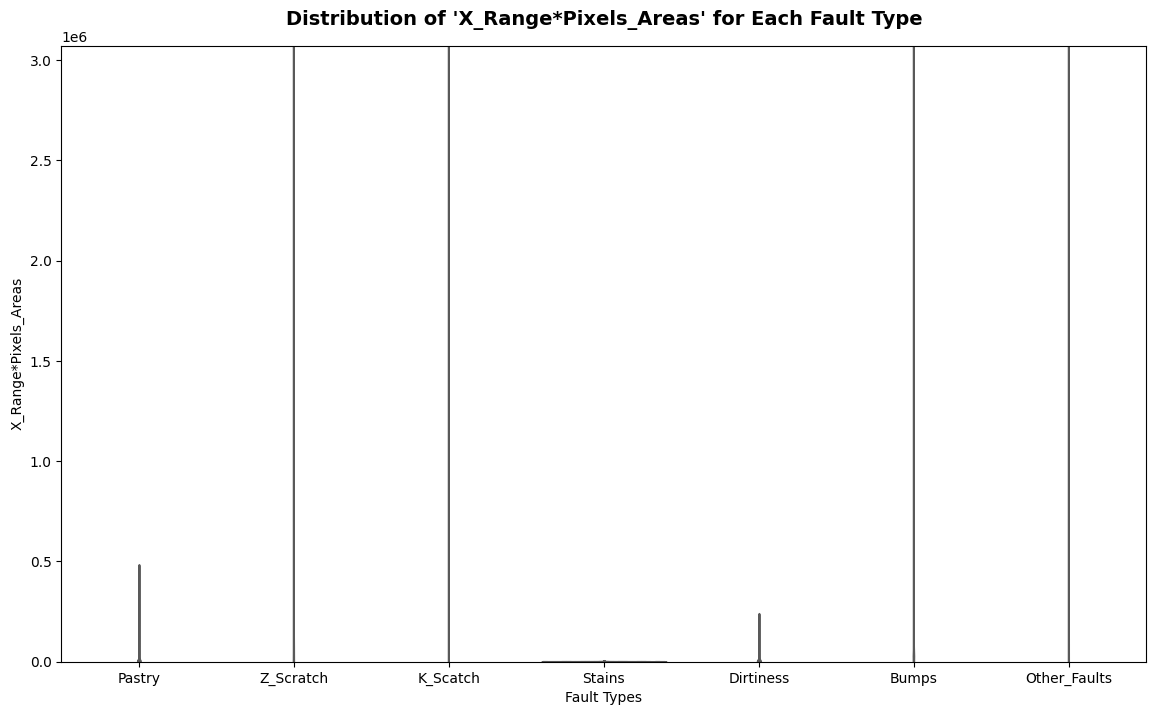

In [8]:
# Create a new DataFrame for plotting
plot_data = pd.melt(train_data, id_vars=['X_Range*Pixels_Areas'], value_vars=TARGET_FEATURES, 
                    var_name='Fault_Type', value_name='Occurrence')

# Filter out rows where the occurrence is 0
plot_data = plot_data[plot_data['Occurrence'] > 0]

# Plotting 
plt.figure(figsize=(14, 8))
palette = sns.color_palette("Set2", len(TARGET_FEATURES))
sns.violinplot(x='Fault_Type', y='X_Range*Pixels_Areas', data=plot_data, inner='quartile', palette=palette)
plt.title("Distribution of 'X_Range*Pixels_Areas' for Each Fault Type", fontweight="black", size=14, pad=15)
plt.xticks()
plt.ylim(0, plot_data['X_Range*Pixels_Areas'].quantile(0.99)) 
plt.xlabel('Fault Types')
plt.ylabel('X_Range*Pixels_Areas')
plt.show()

#### Clustering

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

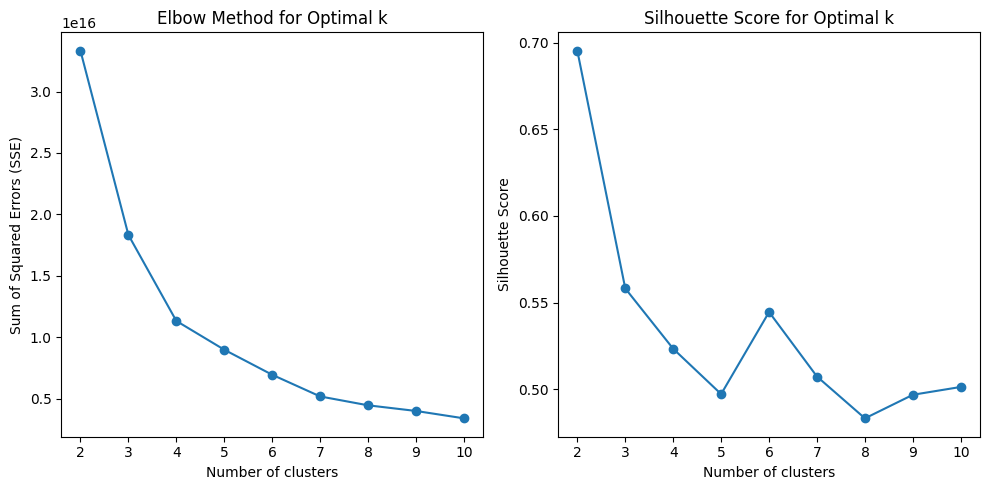

In [9]:
# 클러스터링에 사용할 특성 선택
clustering_features = ['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Steel_Plate_Thickness']

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
sse = []
silhouette_scores = []
k_range = range(2, 11)


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data[clustering_features])
    sse.append(kmeans.inertia_)  # SSE
    silhouette_avg = silhouette_score(train_data[clustering_features], kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# SSE (Elbow Method) 그래프
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')

# 실루엣 스코어 그래프
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()